##Stock price prediction Model with a Convolutional Neural Network

- Extracting the data using the yfinance api and the pandas dataframe package
- 


In [ ]:
!pip install yfinance
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn; sn.set()
import yfinance as yf


To choose stocks that would be best to test accuracy of the CNN with, we used several stock screeners such as TD Ameritrade and Yahoo Finance. With the use of these platforms we were able to filter through tens of thousands of stocks and choose the ones that would be more accurate to predict stock price with. Some of the factors used to filter through the different stocks include : P/E ratio, EPS, Beta score, Profit Margin, Price ratios, etc.

In [ ]:
val = input("Enter your ticker: ")#input
df = yf.download(tickers=val,period='5y',interval='1d')
plt.plot(df['Close'])

Enter your ticker: 2


NameError: ignored

In [ ]:
df.dtypes
def plot(data):
    plt.figure(figsize=(22,6)) #set the size of the figure
    plt.plot(data['Open'], color='blue', label="Open")
    plt.plot(data['High'], color='green', label="High")
    plt.plot(data['Low'], color='red', label="Low")
    plt.plot(data['Close'], color='purple', label="Close")
    plt.title(str(val + " Daily Stock Price\n"+str(data.index[0].date())+" to "+str(data.index[-1].date())))
    plt.xlabel("Date")
    plt.ylabel("Price in USD")
    plt.legend()
    plt.show()

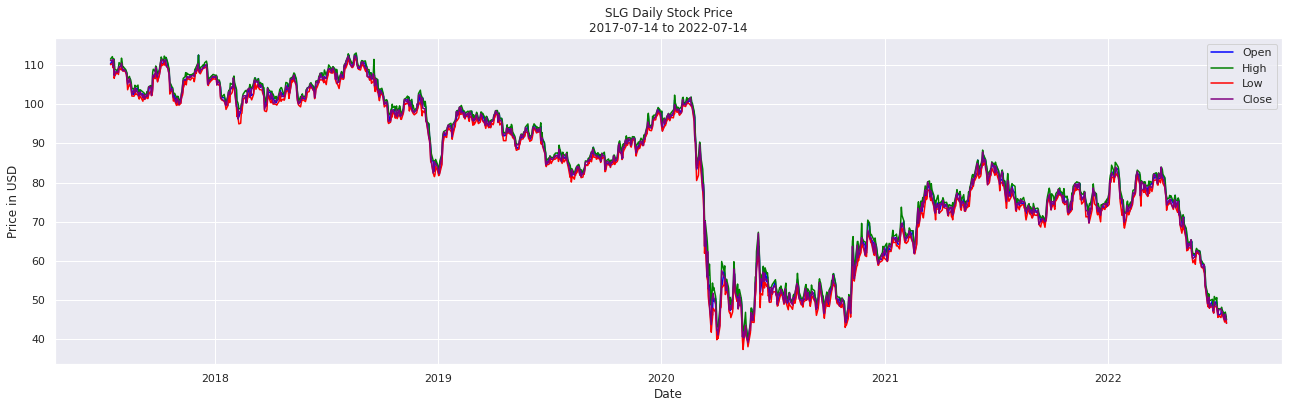

In [ ]:
plot(df)

In [ ]:
#helper function to split the time series (explained in next block of code)
def split_sequence(sequence, n_steps):
	X, y = list(), list() #create empty lists to store X and y variables
	for i in range(len(sequence)):

		# find the end of this pattern
		end_ix = i + n_steps

		# check if we are beyond the sequence
		#if we are, simply stop executing this block of code
		if end_ix > len(sequence)-1:
			break

		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 	

In [ ]:
seq_length = 5 #seq_length tells how many sequential data points are used for each element of the array
#5 means 5 data points will be used at a time
#for instance, the first element of the array will be data points 1-5
#the second element of the array will be data points 2-6
#third element will be data points 3-7, and so on

#we only need the close price data for our model
stock_data = np.array(df['Close'])

#splitting the data with our helper function
X, y = split_sequence(stock_data, seq_length)

In [ ]:
#reshape from [samples, timesteps] into [samples, timesteps, features] for training the model
#the model requires these three values for input
n_features = 1 #our only feature, or input variable, is the closing stock price
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
import tensorflow as tf #backend for keras
from tensorflow import keras #used for creating the CNN model
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D #the data is 1-dimensional so we will use a 1d convolution layer

In [ ]:
#define/setup model
model = Sequential()

#add a 1d convolutional layer
#64 filters used in the convolution operation (a somewhat arbitrary choice)
#kernel_size of 2 means the convolutional layer reads 2 data points at a time, applies the filters, and outputs it to the next layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, n_features)))

#add a pooling layer, which reduces the dimensionality of the input size
#takes the max value of each window of length 2
model.add(MaxPooling1D(pool_size=2))

#flattens the data into a 1d vector - first layer of the fully connected layers
model.add(Flatten())

#dense layer with relu activation
#outputs zero for values less than or equal to zero and keeps positive values the same
model.add(Dense(50, activation='relu'))

#1d dense layer to generate the predicted value
#only 1 dimensional because only one value is being predicted at each time point
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
#the model is fitted on the training data over 100 epochs to improve and update its parameters
#verbose controls how detailed the output is when training the model
def fit_model(X, y):
    """Trains the neural network"""
    model.fit(X, y, epochs=100, verbose=2)

In [ ]:
fit_model(X,y)

Epoch 1/100
40/40 - 1s - loss: 1748.7101 - 840ms/epoch - 21ms/step
Epoch 2/100
40/40 - 0s - loss: 20.3156 - 77ms/epoch - 2ms/step
Epoch 3/100
40/40 - 0s - loss: 7.4380 - 111ms/epoch - 3ms/step
Epoch 4/100
40/40 - 0s - loss: 7.2740 - 71ms/epoch - 2ms/step
Epoch 5/100
40/40 - 0s - loss: 7.3000 - 79ms/epoch - 2ms/step
Epoch 6/100
40/40 - 0s - loss: 7.2949 - 72ms/epoch - 2ms/step
Epoch 7/100
40/40 - 0s - loss: 7.2245 - 71ms/epoch - 2ms/step
Epoch 8/100
40/40 - 0s - loss: 7.2805 - 75ms/epoch - 2ms/step
Epoch 9/100
40/40 - 0s - loss: 7.2581 - 71ms/epoch - 2ms/step
Epoch 10/100
40/40 - 0s - loss: 7.1696 - 92ms/epoch - 2ms/step
Epoch 11/100
40/40 - 0s - loss: 7.1062 - 105ms/epoch - 3ms/step
Epoch 12/100
40/40 - 0s - loss: 6.9596 - 69ms/epoch - 2ms/step
Epoch 13/100
40/40 - 0s - loss: 6.9131 - 72ms/epoch - 2ms/step
Epoch 14/100
40/40 - 0s - loss: 6.7468 - 73ms/epoch - 2ms/step
Epoch 15/100
40/40 - 0s - loss: 6.5945 - 67ms/epoch - 2ms/step
Epoch 16/100
40/40 - 0s - loss: 6.4740 - 72ms/epoch - 2m

In [ ]:
def make_predictions(X, DAYS_TO_PREDICT):
    test_seq = X[-1:] #set the test sequence to start at the most recent stock values
    preds = [] #create empty list to store predictions

    #create predictions using most recent 5 data points
    #the first prediction will assist in making the second prediction, and so on
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq) #outputs the prediction from our test sequence
        pred = y_test_pred #assign pred to the raw output of the model for rebuilding new_seq and test_seq
        preds.append(y_test_pred) #add the prediction to the list we will use for plotting
        new_seq = test_seq.flatten() #flatten the output from the model into a 1d array
        new_seq = np.append(new_seq, [pred]) #add prediction to the list the model is using to make predictions
        new_seq = new_seq[1:] #exclude the first element from the list; use our most recent prediction for the next prediction instead
        test_seq = new_seq.reshape(1, seq_length, 1) #reshape for the model
    preds=np.array(preds).reshape(DAYS_TO_PREDICT,) #reshape the prediction array for plotting
    return preds

In [ ]:
predicted_price=make_predictions(X, 7)
DAYS_TO_PREDICT = 7

In [ ]:
def make_pred_index(data, preds):
    """creating the datetime index for our predictions to be just after our actual data"""
    predicted_index = pd.date_range(start=data.index[-1], #start 1 day beyond existing data
                                    periods=DAYS_TO_PREDICT+1, #run time interval through days predicted
                                    closed='right') #include the last value of the time frame
    return predicted_index

def make_pred_series(preds, predicted_index):
    """create new series of predicted prices with corresponding dates predicted"""
    predicted_price = pd.Series(data=preds,
                                index=predicted_index)
    return predicted_price

In [ ]:
predicted_index = make_pred_index(df, predicted_price)
predicted_price = make_pred_series(predicted_price, predicted_index)
predicted_index
predicted_price

2022-07-15    45.445335
2022-07-16    44.581802
2022-07-17    44.650887
2022-07-18    44.314587
2022-07-19    44.410172
2022-07-20    44.297894
2022-07-21    44.353401
Freq: D, dtype: float32

In [ ]:
def plot_predictions_recent(data, predictions):
    plt.figure(figsize=(15,6))
    #plot data used for training the model
    plt.plot(data[data.index>="2020-08-01"]['Close'][:-1],
            label='Historical Daily Price')

    #add the predcited prices to the plot
    plt.plot(predictions, '.-',
            label='Predicted Daily Price')
    plt.title(val+" daily closing price (2020)\nPrediction for "+str(predictions.index[0].date())+" to "+str(predictions.index[-1].date()))
    plt.legend()
    plt.show()

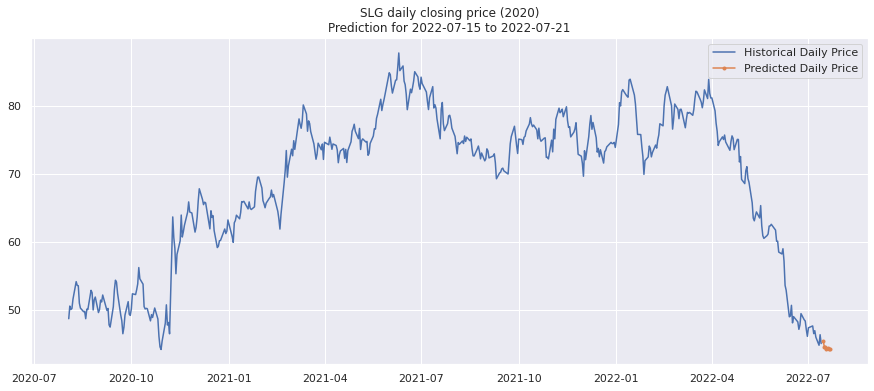

In [ ]:
plot_predictions_recent(df, predicted_price)

In [ ]:
df_backtest = df[:-5] # remove the last 5 data points to keep the most recent full week
df_backtest

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-07-14,110.376167,111.544060,110.131973,111.161835,82.966400,551653
2017-07-17,111.055664,112.181084,110.439873,111.352943,83.109024,624742
2017-07-18,111.098137,111.597145,109.356918,109.717903,81.888710,756039
2017-07-19,109.813454,111.437881,109.813454,111.384796,83.132835,409713
2017-07-20,110.397400,111.565292,106.638924,107.382126,80.145393,1395098
...,...,...,...,...,...,...
2022-06-30,46.410000,46.990002,45.520000,46.150002,46.150002,769100
2022-07-01,45.980000,47.720001,45.980000,47.410000,47.410000,657500
2022-07-05,46.509998,47.680000,45.490002,47.680000,47.680000,1170500


In [ ]:
#we only need the close price data for our model
data_bt = np.array(df_backtest['Close'])

#splitting the data with our helper function
X_bt, y_bt = split_sequence(data_bt, seq_length)

In [ ]:
#reshape from [samples, timesteps] into [samples, timesteps, features] for training the model
#the model requires these three values for input
n_features = 1 #our only feature, or input variable, is the closing stock price
X_bt = X_bt.reshape((X_bt.shape[0], X_bt.shape[1], n_features))

In [ ]:
#define/setup model
model_bt = Sequential()

#add a 1d convolutional layer
#64 filters used in the convolution operation (a somewhat arbitrary choice)
#kernel_size of 2 means the convolutional layer reads 2 data points at a time, applies the filters, and outputs it to the next layer
model_bt.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, n_features)))

#add a pooling layer, which reduces the dimensionality of the input size
#takes the max value of each window of length 2
model_bt.add(MaxPooling1D(pool_size=2))

#flattens the data into a 1d vector - first layer of the fully connected layers
model_bt.add(Flatten())

#dense layer with relu activation
#outputs zero for values less than or equal to zero and keeps positive values the same
model_bt.add(Dense(50, activation='relu'))

#1d dense layer to generate the predicted value
#only 1 dimensional because only one value is being predicted at each time point
model_bt.add(Dense(1))

model_bt.compile(optimizer='adam', loss='mse')

In [ ]:
model_bt.fit(X_bt, y_bt, epochs=100)

Epoch 1/100
40/40 [==============================] - 1s 5ms/step - loss: 2320.2227
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 30.2002
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 6.7436
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 6.5912
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 6.6042
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 6.5887
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 6.5268
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 6.5493
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 6.5906
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 6.5321
Epoch 11/100
40/40 [==============================] - 0s 2ms/step - loss: 6.4731
Epoch 12/100
40/40 [==============================] - 0s 2ms/step - loss: 6.4774
Epoch 13/100
40/40 [=============

In [ ]:
DAYS_TO_PREDICT = 7
def make_predictions_bt(X, DAYS_TO_PREDICT):
    test_seq = X[-1:] #set the test sequence to start at the most recent stock values
    preds = [] #create empty list to store predictions
    #create predictions using most recent 5 data points
    #the first prediction will assist in making the second prediction, and so on
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model_bt(test_seq) #outputs the prediction from our test sequence
        pred = y_test_pred #assign pred to the raw output of the model for rebuilding new_seq and test_seq
        preds.append(y_test_pred) #add the prediction to the list we will use for plotting
        new_seq = test_seq.flatten() #flatten the output from the model into a 1d array
        new_seq = np.append(new_seq, [pred]) #add prediction to the list the model is using to make predictions
        new_seq = new_seq[1:] #exclude the first element from the list; use our most recent prediction for the next prediction instead
        test_seq = new_seq.reshape(1, seq_length, 1) #reshape for the model
    preds=np.array(preds).reshape(DAYS_TO_PREDICT,) #reshape the prediction array for plotting
    return preds

In [ ]:
predicted_price_bt = make_predictions_bt(X_bt, 7)

In [ ]:
predicted_index_bt = make_pred_index(df_backtest, predicted_price_bt)
predicted_price_bt = make_pred_series(predicted_price_bt, predicted_index_bt)

def plot_predictions(data, predictions):
    """Takes the dataframe of historical data and Series of predictions as input"""
    plt.figure(figsize=(15,6))
    plt.plot(data['Close'][:-1], #plot data used for training the model
         label='Historical Daily Price')
    
    plt.plot(predictions, '.-', #plot predictions
             label='Predicted Daily Price')
    plt.title(val+" daily closing price (2020)\nPrediction for "+str(predictions.index[0].date())+" to "+str(predictions.index[-1].date()))
    plt.legend()
    plt.show()

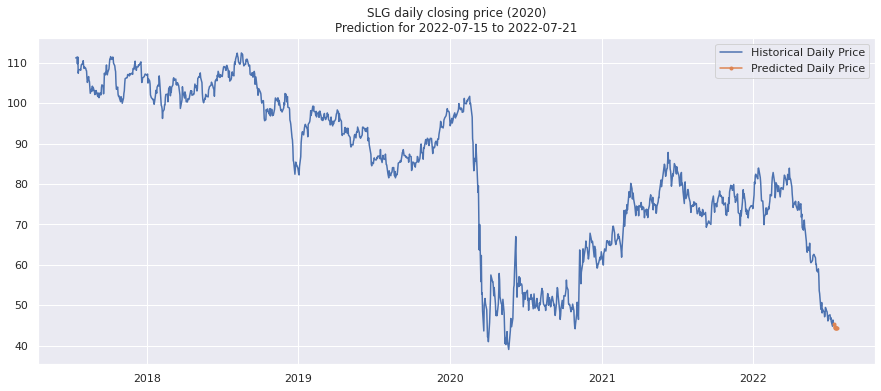

In [ ]:
plot_predictions(df, predicted_price)

In [ ]:
predicted_price

2022-07-15    45.445335
2022-07-16    44.581802
2022-07-17    44.650887
2022-07-18    44.314587
2022-07-19    44.410172
2022-07-20    44.297894
2022-07-21    44.353401
Freq: D, dtype: float32